# imports packages

In [6]:
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

import sweetviz as sv
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from pathlib import Path
import pickle, sys, os
import datetime
import matplotlib.pyplot as plt
import joblib

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, auc, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from imblearn.pipeline import Pipeline
import time

import csv
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)


# Funcstions + Model

In [7]:
def feature_engineering(data, train=True):

    port_cols = ['source_port', 'dest_port', 'nat_source_port', 'nat_dest_port']
    if train:
        # remove errors rows
        data = data[~((data["action"]=='allow') & (data["source_port"]==0) & (data["dest_port"]==0) & (data["nat_source_port"]==0) & (data["nat_dest_port"]==0))]

    # feature engineering
    
    # add time related columns 
    data.loc[:,"datetime"] = data["timestamp"].apply(lambda v: datetime.datetime.fromtimestamp(v * 0.001))
    data.loc[:,"day"] = data["datetime"].dt.day
    data.loc[:,"hour"] = data["datetime"].dt.hour
    data.loc[:,"year"] = data["datetime"].dt.year
    data.loc[:,"dayofweek"] = data["datetime"].dt.dayofweek

    # add calculated columns
    data.loc[:,'avg_bytes_received_per_packet'] = data['bytes_received'].div(data['packets_received']).replace({np.inf: 0, np.nan: 0})
    data.loc[:,'avg_bytes_sent_per_packet'] = data['bytes_sent'].div(data['packets_sent']).replace({np.inf: 0, np.nan: 0})
    data.loc[:,'avg_bytes_per_packet'] = data['bytes'].div(data['packets']).replace({np.inf: 0, np.nan: 0})
    data.loc[:,"packets_transfer_fraction"] = data['packets_sent'].div(data['packets_received']).replace({np.inf: 0, np.nan: 0})
    data.loc[:,'packets_per_rel_time'] = data['packets_sent'].div(data['timestamp_relative']).replace({np.inf: 0, np.nan: 0})
    
    # create one hot vector representation for action columns
    data = pd.get_dummies(data, columns=['action'], prefix=['action'])
    
    action_cols = ['action_allow', 'action_deny', 'action_drop', 'action_reset-both']
    for col in action_cols:
        if col not in data.columns:
            data[col] = 0
    
    # create a special column for dest_port=53 - which is relrevent for the flood attack
    data['is_dest_port_53'] = 0
    data.loc[data["dest_port"]==53, 'is_dest_port_53'] = 1
    
    # categorize prot numbers + one hot vector representation
    labels = ["Well Known Ports","Registered Ports","Dynamic and/or Private Ports"]
    for col in port_cols:
        ''' port numbers are divided into three categories: Well Known Ports (0 ∼ 1023), Registered Ports
            (1024 ∼ 49151), and Dynamic and/or Private Ports (49152 ∼ 65535)'''
        data[f"{col}_cat"] = pd.cut(data[col], [0, 1024, 49152, 65536],
                           labels=labels,
                           #include_lowest=True, 
                           right=False
                          )
        data = pd.get_dummies(data, columns=[f"{col}_cat"], prefix=[f"{col}_cat"])
        data.drop([col], axis=1, inplace=True)
        for l in labels:
            if f"{col}_cat_{l}" not in data.columns:
                data[f"{col}_cat_{l}"] = 0
    data.drop(["datetime"], axis=1, inplace=True) 
    return data


def data_exploration_preprocessing(train, visalizatoin=False):
    features = train.columns.tolist()
    
    # Find features with correlation greater than 0.95 to drop
    corr_matrix = train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    
    # drop columns with constant values
    for feat in features:
        if train[feat].nunique() == 1:
            to_drop.append(feat)
            
    use_cols = list(set(features)-set(to_drop))
            
    if visalizatoin:
        train.describe().to_csv(r"output/describe.csv")
        report = ProfileReport(train, title="Pandas Profiling Report")
        report.to_file(r"Output/report.html")
        my_report = sv.analyze(train)  
        my_report.show_html(filepath=r"Output/SWEETVIZ_REPORT.html")

    return use_cols


class FeatureEngineeringTransformer(BaseEstimator):
    def __init__(self):
        super().__init__()
        self.log_columns = None
        self.use_cols=None

    def fit(self, X, y=None):
        self.use_cols = data_exploration_preprocessing(X)
        return self

    def transform(self, X, y=None):
#         list_cols = list(set(X)-set(self.use_cols))
        list_cols = [c for c in self.use_cols if c in X.columns]
        X = X[list_cols]
        return X

def plot_roc_curve(y, y_score):
    fpr, tpr, thresholds = roc_curve(y, y_score)

    fig = px.area(
        x=fpr, y=tpr,
        title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='False Positive Rate', y='True Positive Rate'),
        width=700, height=500
    )
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show()


def predict_on_test(X_test, y_test, model=None):
    if model is None and Path(f'Output/bestEstimator.pkl').exists():
        model = joblib.load(f"Output/bestEstimator.pkl")
    y_test_prediction = model.predict(X_test)
    plot_roc_curve(y_test, y_test_prediction)
    f1 = f1_score(y_test, y_test_prediction)
    accuracy = accuracy_score(y_test, y_test_prediction)
    recall = recall_score(y_test, y_test_prediction)
    precision = precision_score(y_test, y_test_prediction)
    print(f"confusion_matrix: {confusion_matrix(y_test, y_test_prediction)}")
    print(f"accuracy: {accuracy}")
    print(f"recall: {recall}")
    print(f"precision: {precision}")
    print(f"f1: {f1}")
    return f1_score, accuracy, precision, recall


def predict(X):
    prediction = None
    model = joblib.load(f"Output/bestEstimator.pkl")
    prediction = model.predict(X)
    return prediction

def train(model_name, X,  y, steps):
    cv = KFold(n_splits=3, random_state=1, shuffle=True)
    # Fit the model according to the given training data
    pipeline = Pipeline(steps=steps)
    scores = cross_val_score(pipeline, X, y, scoring='f1_weighted', cv=cv)
    with open(f'Output/results.csv', 'a') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow([model_name, scores.mean(), scores.std()])
    return scores.mean(), scores.std()


def run(X_train, y_train, X_test, y_test, dict_models):
    results_path = f'Output/results.csv'
    if not os.path.exists(results_path):
        with open(results_path, 'a') as csvfile:
            csvwriter = csv.writer(csvfile)
            # writing the fields
            csvwriter.writerow(["model_name", "scores_mean", "scores_std"])
    
    for model_name in dict_models.keys():
        steps = [
            ('feature_engineering', FeatureEngineeringTransformer()),
            ('scaling', StandardScaler()),
            ('PCA', PCA(n_components=10))]
        scores = pd.read_csv(results_path)
        if model_name not in scores['model_name'].unique():
            steps.append(('model', dict_models[model_name]))
            print (f"running model {model_name}")
            t0 = time.time()
            train(model_name, X_train, y_train, steps)
            t1 = time.time()
            print (f"Total time:{t1-t0}")
    scores = pd.read_csv(results_path)
    scores = scores.sort_values("scores_mean")
    best_model_name = scores['model_name'].iloc[0]
    steps = [
            ('feature_engineering', FeatureEngineeringTransformer()),
            ('scaling', StandardScaler()),
            ('PCA', PCA(n_components=20))]
    print (f"best model found: {best_model_name}")
    steps.append(('model', dict_models[best_model_name]))
    pipeline = Pipeline(steps=steps)
    pipeline.fit(X_train)
    joblib.dump(pipeline, f"Output/bestEstimator.pkl", compress=1)
    predict_on_test(X_test, y_test, model=pipeline)
    

# One-class classification

In one-class classification we are always dealing with a two-class classification problem, where each of the two classes have a special meaning.The two classes are called the target and the outlier class respectively:
- target class: this class is assumed to be sampled well, in the sense that of this class many (training) example objects are available. It does not necessarily mean that the sampling of the training set is done completely according to the target distribution found in practice.It is assumed though, that the training data reflect the area that the target data covers in the feature space.
- outlier class: this class can be sampled very sparsely, or can be totally absent.

I will compare three models for outliers/anomaly detection: 
1. OneClassSVM
2. IForest
3. RobustCovariance

# Load Data + Data exploration + Processing 

statistical info of data can be find in Output folder

- since ports number have many unique values I have decided to categorize them to 3 sections and then do one hot vector representation.
- some features are highly correlated
- some features are skewd 
- there are no missing data
- unrelevant rows were removed

# Process: 

1. add engeneered columns + transform categorical columns to one hot vector representation
2. remove constant columns + highly correlated columns
3. scaling 
4. dimenstion reduction using pca
5. train model
6. select best model on k-fold
7. test on unseen results

# Ideas for future work:

1. exmaing more hyper-parameters tuning for the compared models/PCA
2. examine different feature selection models/dimension reduction 
3. use oversampling/undersampling
4. compare to rule based model

In [8]:
seed = 1
train_model = False
if train_model:
    add_atack_to_train = True
    df = pd.read_csv('ex_data.csv')
    df = feature_engineering(df)
    df['label'] = 1
    df.loc[df["timestamp"]==1552695187200, 'label'] = -1
    feat_cols = list(df.columns)
    feat_cols.remove('label')

    display(df)

    X = df.loc[df["label"]!=-1, feat_cols]
    y = df.loc[df["label"]!=-1, 'label']
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

    attack_x = df.loc[df["label"]==-1, feat_cols]
    attack_y = df.loc[df["label"]==-1, 'label']

    X_test = pd.concat([X_test, attack_x], ignore_index=True)
    y_test = pd.concat([y_test, attack_y], ignore_index=True)

    if add_atack_to_train:
        X_train = pd.concat([X_train, attack_x], ignore_index=True)
        y_train = pd.concat([y_train, attack_y], ignore_index=True)

    data_exploration_preprocessing(X_train, visalizatoin=True)
    
    outliers_fraction = 0.00001
    algo_dict = {"OneClassSVM": svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1),
            "IForest": IsolationForest(contamination=outliers_fraction, n_estimators=10, warm_start=True),
            "RobustCovariance": EllipticEnvelope(contamination=outliers_fraction)
               }

    run(X_train, y_train, X_test, y_test, algo_dict)

,bytes,bytes_sent,bytes_received,packets,time_elapsed_sec,timestamp,ts_ret_a,timestamp_relative,packets_sent,packets_received,...,dest_port_cat_Well Known Ports,dest_port_cat_Registered Ports,dest_port_cat_Dynamic and/or Private Ports,nat_source_port_cat_Well Known Ports,nat_source_port_cat_Registered Ports,nat_source_port_cat_Dynamic and/or Private Ports,nat_dest_port_cat_Well Known Ports,nat_dest_port_cat_Registered Ports,nat_dest_port_cat_Dynamic and/or Private Ports,label
0,177,94,83,2,30,1552573800000,0,0,1,1,...,1,0,0,0,0,1,1,0,0,1
1,4768,1600,3168,19,17,1552573800720,720,30,10,9,...,0,1,0,0,0,1,0,1,0,1
2,238,118,120,2,1199,1552573801128,1128,47,1,1,...,0,0,1,0,1,0,0,0,1,1
3,3327,1438,1889,15,17,1552573829904,29904,1246,8,7,...,0,1,0,0,0,1,0,1,0,1
4,25358,6778,18580,31,16,1552573830312,30312,1263,13,18,...,1,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77022,18738,1904,16834,33,17,1552695184632,95598072,3983253,17,16,...,1,0,0,0,0,1,1,0,0,1
77023,184,94,90,2,30,1552695185040,95598480,3983270,1,1,...,1,0,0,0,1,0,1,0,0,1
77024,212,102,110,2,30,1552695185760,95599200,3983300,1,1,...,1,0,0,0,0,1,1,0,0,1
77025,177,94,83,2,30,1552695186480,95599920,3983330,1,1,...,1,0,0,0,0,1,1,0,0,1



Report Output/SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
best model found: OneClassSVM


confusion_matrix: [[    1     0]
 [ 4882 14349]]
accuracy: 0.7461522462562395
recall: 0.746139046331444
precision: 1.0
f1: 0.8546158427635497


# Serving the model

In [9]:
def predict_data(data):
    data = feature_engineering(data, train=False)
    return predict(data)

sample_predict = pd.read_csv('ex_data.csv').sample(5)
prediction = predict_data(sample_predict)

# prediction histogram

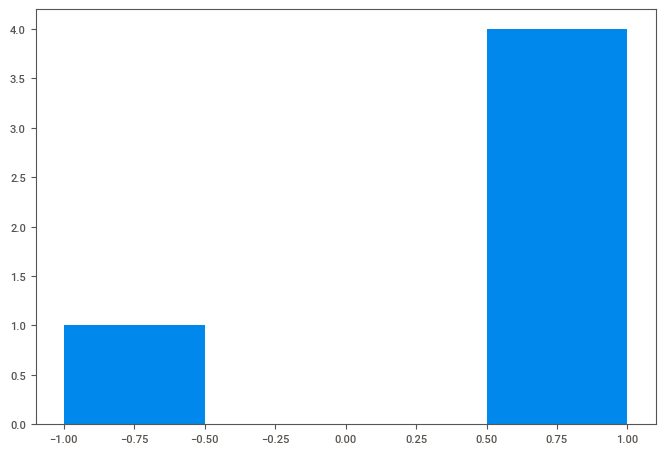

In [10]:
_ = plt.hist(prediction, bins='auto')  # arguments are passed to np.histogram
plt.show()